In [61]:
import numpy as np
from numba import vectorize, njit

import utils
from het_block import het
from simple_block import simple

In [62]:
@het(exogenous='Pi', policy='a', backward='Va')
def household(Va_p, Pi_p, a_grid, e_grid, w, r, beta, eis, frisch, vphi, c_const, n_const, ssflag=False):
    """Single backward iteration step using endogenous gridpoint method for households with separable CRRA utility."""
    # this one is useful to do internally
    ws = w * e_grid

    # uc(z_t, a_t)
    uc_nextgrid = (beta * Pi_p) @ Va_p

    # c(z_t, a_t) and n(z_t, a_t)
    c_nextgrid, n_nextgrid = cn(uc_nextgrid, ws[:, np.newaxis], eis, frisch, vphi)

    # c(z_t, a_{t-1}) and n(z_t, a_{t-1})
    lhs = c_nextgrid - ws[:, np.newaxis] * n_nextgrid + a_grid[np.newaxis, :]
    rhs = (1 + r) * a_grid
    c = utils.interpolate_y(lhs, rhs, c_nextgrid)
    n = utils.interpolate_y(lhs, rhs, n_nextgrid)

    # test constraints, replace if needed
    a = rhs + ws[:, np.newaxis] * n - c
    iconst = np.nonzero(a < a_grid[0])
    a[iconst] = a_grid[0]

    if ssflag:
        # use precomputed values
        c[iconst] = c_const[iconst]
        n[iconst] = n_const[iconst]
    else:
        # have to solve again if in transition
        uc_seed = c_const[iconst] ** (-1 / eis)
        c[iconst], n[iconst] = solve_cn(ws[iconst[0]],
                                        rhs[iconst[1]] - a_grid[0], eis, frisch, vphi, uc_seed)

    # calculate marginal utility to go backward
    Va = (1 + r) * c ** (-1 / eis)

    # efficiency units of labor which is what really matters
    ns = e_grid[:, np.newaxis] * n

    return Va, a, c, n, ns


@njit
def cn(uc, w, eis, frisch, vphi):
    """Return optimal c, n as function of u'(c) given parameters"""
    return uc ** (-eis), (w * uc / vphi) ** frisch


def solve_cn(w, T, eis, frisch, vphi, uc_seed):
    uc = solve_uc(w, T, eis, frisch, vphi, uc_seed)
    return cn(uc, w, eis, frisch, vphi)


@vectorize
def solve_uc(w, T, eis, frisch, vphi, uc_seed):
    """Solve for optimal uc given in log uc space.

    max_{c, n} c**(1-1/eis) + vphi*n**(1+1/frisch) s.t. c = w*n + T
    """
    log_uc = np.log(uc_seed)
    for i in range(30):
        ne, ne_p = netexp(log_uc, w, T, eis, frisch, vphi)
        if abs(ne) < 1E-11:
            break
        else:
            log_uc -= ne / ne_p
    else:
        raise ValueError("Cannot solve constrained household's problem: No convergence after 30 iterations!")

    return np.exp(log_uc)


@njit
def netexp(log_uc, w, T, eis, frisch, vphi):
    """Return net expenditure as a function of log uc and its derivative."""
    c, n = cn(np.exp(log_uc), w, eis, frisch, vphi)
    ne = c - w * n - T

    # c and n have elasticities of -eis and frisch wrt log u'(c)
    c_loguc = -eis * c
    n_loguc = frisch * n
    netexp_loguc = c_loguc - w * n_loguc

    return ne, netexp_loguc


In [100]:
'''Part 2: Simple blocks and hetinput'''


@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y


@simple
def mkt_clearing(A, NS, C, L, Y, K, I):
    asset_mkt = A - K
    labor_mkt = NS - L
    goods_mkt = Y - C - I
    return asset_mkt, labor_mkt, goods_mkt


In [101]:
'''Part 3: Steady state'''

def ksl_ss(beta_guess=0.98,vphi_guess=0.98, r=0.01, delta=0.025, alpha =1/3, eis=1, frisch=1,
           rho_s=0.9, sigma_s=0.3, nS=8, amax=100, nA=500):
    """Solve steady state of full GE model. Calibrate (beta, vphi) to hit target for interest rate and Y."""

    # set up grid
    a_grid = utils.agrid(amax=amax, n=nA)
    e_grid, pi_e, Pi = utils.markov_rouwenhorst(rho=rho_s, sigma=sigma_s, N=nS)
    
    # solve analytically what we can
    rk = r + delta
    Z = (rk / alpha) ** alpha  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    w = (1 - alpha) * Z * (alpha * Z / rk) ** (alpha / (1 - alpha))
    I = delta * K

    # initialize guess for policy function iteration
    fininc = (1 + r) * a_grid - a_grid[0]
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)

    # residual function
    def res(x):
        beta_loc, vphi_loc = x
        # precompute constrained c and n which don't depend on Va
        c_const_loc, n_const_loc = solve_cn(w * e_grid[:, np.newaxis],fininc, eis, frisch, vphi_loc, Va)
        if beta_loc > 0.999 / (1 + r) or vphi_loc < 0.001:
            raise ValueError('Clearly invalid inputs')
        out = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta_loc,
                           eis=eis, frisch=frisch, vphi=vphi_loc, c_const=c_const_loc, n_const=n_const_loc,ssflag=True)
        return np.array([out['A'] - K, out['NS'] - 1])

    # solve for beta, vphi
    (beta, vphi), _ = utils.broyden_solver(res, np.array([beta_guess, vphi_guess]), noisy=False)

    # extra evaluation for reporting
    c_const, n_const = solve_cn(w * e_grid[:, np.newaxis],fininc, eis, frisch, vphi, Va)
    ss = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta, eis=eis,
                      frisch=frisch, vphi=vphi, c_const=c_const, n_const=n_const, ssflag=True)
    
    # check Walras's law
    goods_mkt = ss['C'] + I - 1
    assert np.abs(goods_mkt) < 1E-7
    
    # add aggregate variables
    ss.update({'Y': 1, 'L': 1, 'K': K, 'Z': Z, 'I': I, 'w': w, 'r': r,
               'beta': beta, 'vphi': vphi, 'alpha': alpha, 'delta': delta, 
               'frisch': frisch, 'a_grid': a_grid, 'e_grid': e_grid,  'goods_mkt': goods_mkt})
    return ss

In [102]:
ss1=ksl_ss()

In [103]:
ss1.keys()

dict_keys(['a_grid', 'w', 'vphi', 'e_grid', 'beta', 'r', 'frisch', 'eis', 'ssflag', 'c_const', 'n_const', 'Pi', 'Va', 'a', 'c', 'n', 'ns', 'N', 'C', 'NS', 'A', 'D', 'Y', 'L', 'K', 'Z', 'I', 'alpha', 'delta', 'goods_mkt'])

In [104]:
import matplotlib.pyplot as plt

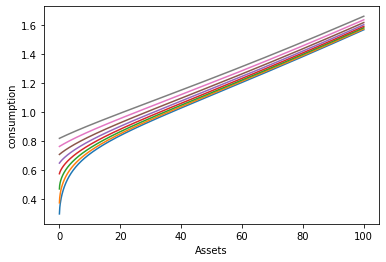

In [105]:
plt.plot(ss1['a_grid'], ss1['c'].T)
plt.xlabel('Assets'), plt.ylabel('consumption')
plt.show()

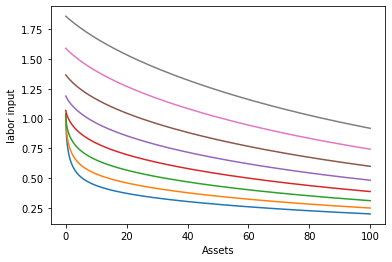

In [106]:
plt.plot(ss1['a_grid'], ss1['n'].T)
plt.xlabel('Assets'), plt.ylabel('labor input')
plt.show()

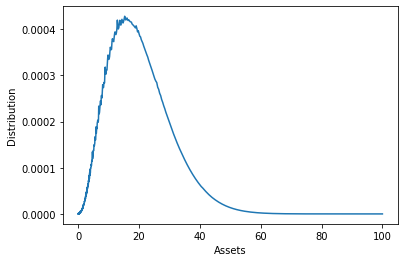

In [107]:
plt.plot(ss1['a_grid'], ss1['D'][6])
plt.xlabel('Assets'), plt.ylabel('Distribution')
plt.show()

In [108]:
import jacobian as jac

In [109]:
T = 300
G1 = jac.get_G(block_list=[firm, mkt_clearing, household],
               exogenous=['Z'],
               unknowns=['K','L'],
               targets=['asset_mkt','labor_mkt'],
               T=T, ss=ss1)

In [110]:
G1.keys()

dict_keys(['C', 'NS', 'N', 'K', 'w', 'Y', 'r', 'L', 'goods_mkt', 'A'])

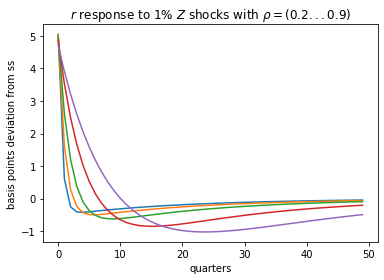

In [111]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
dZ1 = 0.01*ss1['Z']*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
dr = G1['r']['Z'] @ dZ1
plt.plot(10000*dr[:50, :])
plt.title(r'$r$ response to 1% $Z$ shocks with $\rho=(0.2 ... 0.9)$')
plt.ylabel(r'basis points deviation from ss')
plt.xlabel(r'quarters')
plt.show()

In [112]:
def rbc_ss(beta=0.99, vphi = 1, Z = 1, delta=0.025, alpha =1/3, eis=1, frisch=1):
    """Solve steady state of simple RBC model.
        
    Parameters
    ----------
    r      : scalar, real interest rate
    eis    : scalar, elasticity of intertemporal substitution (1/sigma)
    frisch : scalar, Frisch elasticity (1/nu)
    delta  : scalar, depreciation rate
    alpha  : scalar, capital share

    Returns
    -------
    ss : dict, steady state values
    """
    # solve for aggregates analytically
    r = 1/beta - 1
    rk = r + delta
    KL = (rk/alpha/Z) ** (1/(alpha-1))
    L = (1-alpha)*Z*KL**alpha * KL**(-1/eis)/vphi
    L = L*(Z*KL**(alpha-1)-delta)**(-1/eis)
    L = L**(1/(1/eis+1/frisch))
    K = L*KL
    Y = Z * K ** alpha * L ** (1-alpha)
    w = (1 - alpha) * Z * KL ** alpha 
    I = delta * K
    C = Y - I
        
    # check Walras's law
    walras = Y - rk * K - w * L
    assert np.abs(walras) < 1E-12

    return {'beta': beta, 'eis': eis, 'frisch':frisch, 'vphi': vphi, 'delta': delta, 'alpha': alpha,
            'Z': Z, 'K': K, 'I': I, 'Y': Y, 'L': L, 'C': C, 'w': w, 'r': r, 'walras': walras}

In [113]:
ss0 = rbc_ss(beta = ss1['beta'],vphi = ss1['vphi'],Z = ss1['Z'])

In [114]:
[ss0['K'], ss1['K']]

[8.60066887790583, 9.523809523809517]

In [115]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@simple
def household(K, L, w, eis, frisch, vphi, delta):
    C = (w / vphi / L ** (1 / frisch)) ** eis
    I = K - (1 - delta) * K(-1)
    return C, I

@simple
def mkt_clearing(r, C, Y, I, K, L, w, eis, beta):
    goods_mkt = Y - C - I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * L  # we can the check dynamic version too
    return goods_mkt, euler, walras

In [116]:
G0 = jac.get_G(block_list=[firm, household, mkt_clearing],
              exogenous=['Z'],
              unknowns=['K', 'L'],
              targets=['euler', 'goods_mkt'],
              T=300, ss=ss0)

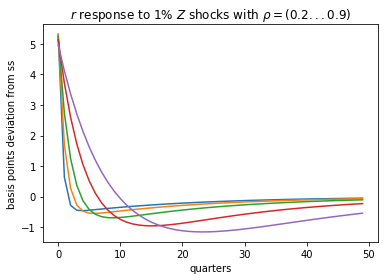

In [117]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
dZ0 = 0.01*ss0['Z']*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
dr = G0['r']['Z'] @ dZ0
plt.plot(10000*dr[:50, :])
plt.title(r'$r$ response to 1% $Z$ shocks with $\rho=(0.2 ... 0.9)$')
plt.ylabel(r'basis points deviation from ss')
plt.xlabel(r'quarters')
plt.show()

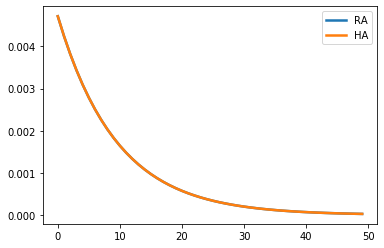

In [118]:
plt.plot(dZ0[:50, 4], label='RA', linewidth=2.5)
plt.plot(dZ1[:50, 4], label='HA', linewidth=2.5)
plt.legend()
plt.show()

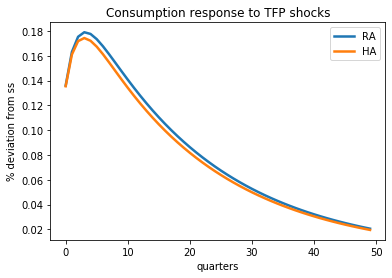

In [119]:
dC0 = 100 * G0['C']['Z'] @ dZ0 / ss0['C']
dC1 = 100 * G1['C']['Z'] @ dZ1 / ss1['C']
plt.plot(dC0[:50,2], label='RA', linewidth=2.5)
plt.plot(dC1[:50,2], label='HA', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

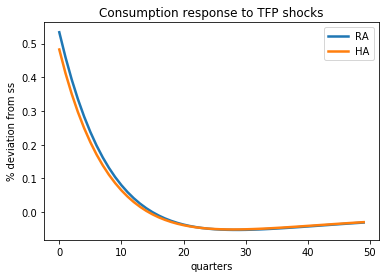

In [120]:
dY0 = 100 * G0['L']['Z'] @ dZ0 / ss0['L']
dY1 = 100 * G1['N']['Z'] @ dZ1 / ss1['L']
plt.plot(dY0[:50,4], label='RA', linewidth=2.5)
plt.plot(dY1[:50,4], label='HA', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

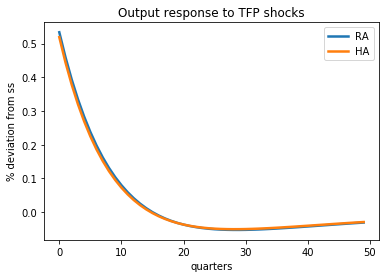

In [121]:
dY0 = 100 * G0['L']['Z'] @ dZ0 / ss0['L']
dY1 = 100 * G1['NS']['Z'] @ dZ1 / ss1['L']
plt.plot(dY0[:50,4], label='RA', linewidth=2.5)
plt.plot(dY1[:50,4], label='HA', linewidth=2.5)
plt.legend()
plt.title(r'Output response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

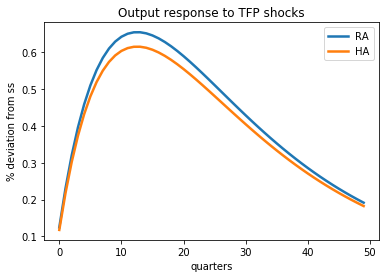

In [122]:
dY0 = 100 * G0['K']['Z'] @ dZ0 / ss0['K']
dY1 = 100 * G1['K']['Z'] @ dZ1 / ss1['K']
plt.plot(dY0[:50,4], label='RA', linewidth=2.5)
plt.plot(dY1[:50,4], label='HA', linewidth=2.5)
plt.legend()
plt.title(r'Output response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

In [123]:
def rbc_ss(beta=0.99, Z = 1, eis=1, frisch=1, delta=0.025, alpha=1/3):
    """Solve steady state of simple RBC model.
        
    Parameters
    ----------
    r      : scalar, real interest rate
    eis    : scalar, elasticity of intertemporal substitution (1/sigma)
    frisch : scalar, Frisch elasticity (1/nu)
    delta  : scalar, depreciation rate
    alpha  : scalar, capital share

    Returns
    -------
    ss : dict, steady state values
    """
    # solve for aggregates analytically
    r = 1/beta - 1
    rk = r + delta
    K = (rk/alpha/Z) ** (1/(alpha-1))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * K ** alpha 
    I = delta * K
    C = Y - I
    vphi = w * C ** (-1 / eis)
    
    # check Walras's law
    walras = Y - rk * K - w
    assert np.abs(walras) < 1E-12

    return {'beta': beta, 'eis': eis, 'frisch':frisch, 'vphi': vphi, 'delta': delta, 'alpha': alpha,
            'Z': Z, 'K': K, 'I': I, 'Y': Y, 'L': 1, 'C': C, 'w': w, 'r': r, 'walras': walras}

In [124]:
ss2 = rbc_ss(beta = ss1['beta'],Z = ss1['Z'])
ss2['L']

1

In [125]:
G2 = jac.get_G(block_list=[firm, household, mkt_clearing],
              exogenous=['Z'],
              unknowns=['K', 'L'],
              targets=['euler', 'goods_mkt'],
              T=300, ss=ss2)

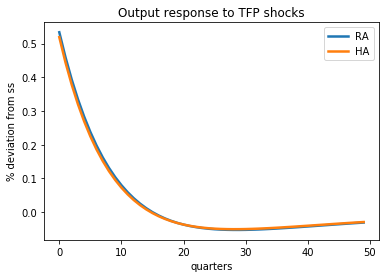

In [126]:
dY2 = 100 * G2['L']['Z'] @ dZ0 / ss2['L']
dY1 = 100 * G1['L']['Z'] @ dZ1 / ss1['L']
plt.plot(dY2[:50,4], label='RA', linewidth=2.5)
plt.plot(dY1[:50,4], label='HA', linewidth=2.5)
plt.legend()
plt.title(r'Output response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

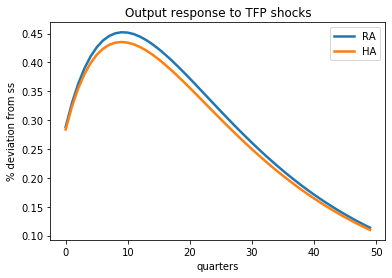

In [127]:
dY2 = 100 * G2['C']['Z'] @ dZ0 / ss2['C']
dY1 = 100 * G1['C']['Z'] @ dZ1 / ss1['C']
plt.plot(dY2[:50,4], label='RA', linewidth=2.5)
plt.plot(dY1[:50,4], label='HA', linewidth=2.5)
plt.legend()
plt.title(r'Output response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

In [128]:
idx= 'L'
[ss0[idx],ss1[idx],ss2[idx]]

[0.9669508904298183, 1, 1]

In [129]:
def rbc_ss(r=0.01, eis=1, frisch=1, delta=0.025, alpha=1/3):
    """Solve steady state of simple RBC model.
        
    Parameters
    ----------
    r      : scalar, real interest rate
    eis    : scalar, elasticity of intertemporal substitution (1/sigma)
    frisch : scalar, Frisch elasticity (1/nu)
    delta  : scalar, depreciation rate
    alpha  : scalar, capital share

    Returns
    -------
    ss : dict, steady state values
    """
    # solve for aggregates analytically
    rk = r + delta
    Z = (rk / alpha) ** alpha  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * K ** alpha
    I = delta * K
    C = Y - I
    
    # preference params
    beta = 1 / (1 + r)
    vphi = w * C ** (-1 / eis)
    
    # check Walras's law
    walras = C - r * K - w
    assert np.abs(walras) < 1E-12

    return {'beta': beta, 'eis': eis, 'frisch':frisch, 'vphi': vphi, 'delta': delta, 'alpha': alpha,
            'Z': Z, 'K': K, 'I': I, 'Y': Y, 'L': 1, 'C': C, 'w': w, 'r': r, 'walras': walras}

In [130]:
ss3 = rbc_ss()

In [131]:
G3 = jac.get_G(block_list=[firm, household, mkt_clearing],
              exogenous=['Z'],
              unknowns=['K', 'L'],
              targets=['euler', 'goods_mkt'],
              T=300, ss=ss3)

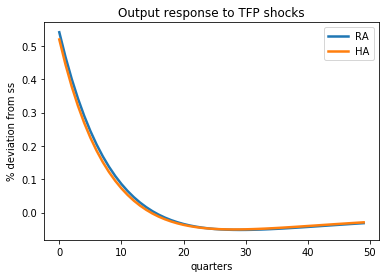

In [132]:
dY3 = 100 * G3['L']['Z'] @ dZ1 / ss3['L']
dY1 = 100 * G1['L']['Z'] @ dZ1 / ss1['L']
plt.plot(dY3[:50,4], label='RA', linewidth=2.5)
plt.plot(dY1[:50,4], label='HA', linewidth=2.5)
plt.legend()
plt.title(r'Output response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

In [133]:
G1.keys()

dict_keys(['C', 'NS', 'N', 'K', 'w', 'Y', 'r', 'L', 'goods_mkt', 'A'])

In [134]:
ss1['L']

1